In [2]:
from src.datasets.heart_dataset import HeartDataset
from src.datasets.german_dataset import GermanDataset
from src.datasets.adult_sampled_dataset import AdultSampledDataset
from src.experiments import init_dataset
random_state = 42

data_path = '../data'
german = GermanDataset(f'{data_path}/german_credit/german.data', binary=True, group_type='',
                             random_state=random_state)
# adult = init_dataset('adult', 42)
german = init_dataset('bank', 42)
heart = HeartDataset(f'{data_path}/heart_disease/processed.cleveland.data', binary=True, group_type='',
                            random_state=random_state)

In [3]:
def get_features_groups_target(df, dataset):
    features = df[[c for c in df.columns if c not in [*dataset.sensitive, dataset.target]]]
    sensitive = df[dataset.sensitive]
    target = df[[dataset.target]]
    return features, sensitive, target

In [4]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

german_df = german.data
german_np = MinMaxScaler().fit_transform(german_df)
german_df = pd.DataFrame(german_np, columns=german_df.columns)
# adult_df = adult.data#adult.perform_encoding('cont_ord_cat', adult.data, adult.data)
# bank_df = bank.data#bank.perform_encoding('cont_ord_cat', bank.data, bank.data)

german_features, german_sensitive, german_target = get_features_groups_target(german_df, german)
# adult_features, adult_sensitive, adult_target = get_features_groups_target(adult_df, adult)
# bank_features, bank_sensitive, bank_target = get_features_groups_target(bank_df, bank)
# dataset = AdultSampledDataset(f'{data_path}/adult_census/sampled_sex/natural.csv', binary=True, group_type='',
#                             random_state=42)
# german_df = dataset.data
# german_np = MinMaxScaler().fit_transform(german_df)
# german_df = pd.DataFrame(german_np, columns=german_df.columns)
# adult_df = adult.data#adult.perform_encoding('cont_ord_cat', adult.data, adult.data)
# bank_df = bank.data#bank.perform_encoding('cont_ord_cat', bank.data, bank.data)

german_features, german_sensitive, german_target = get_features_groups_target(german_df, german)

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA


def pca_visualization(features, sensitive, target):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    pca = PCA(n_components=2)
    pca.fit(features)
    print(pca.explained_variance_ratio_)
    pca_features = pca.transform(features)
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{t}_{s}' for t, s in zip(target.to_list(), sensitive_groups.to_list())]    
    PC1 = pca_features[:,0]
    PC2 = pca_features[:,1]
    df = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'target': target, 'sensitive_groups': sensitive_groups, 'group_class': group_class})
    axs[0] = sns.scatterplot(df, x='PC1', y='PC2', hue='group_class', ax=axs[0])
    sns.scatterplot(df, x='PC2', y='PC1', hue='target', ax=axs[1])
    sns.scatterplot(df, x='PC2', y='PC1', hue='sensitive_groups', ax=axs[2])
    fig.tight_layout()
    plt.show()

[0.25145944 0.20726019]


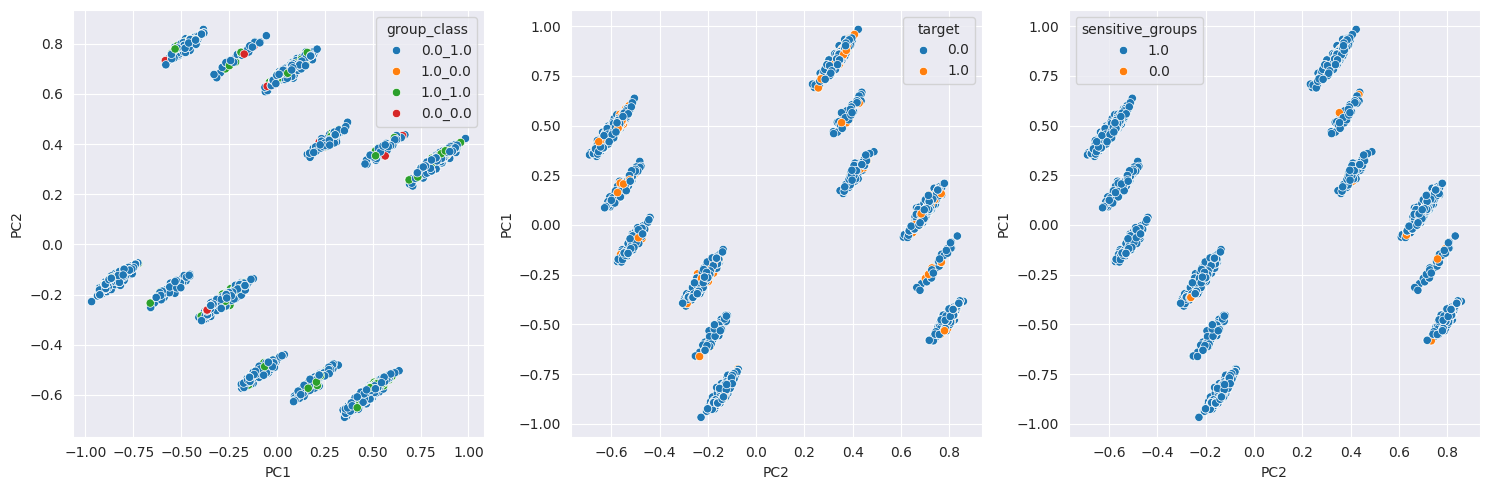

In [6]:
pca_visualization(german_features, german_sensitive, german_target[german.target])

In [7]:
from sklearn.manifold import TSNE
import numpy as np
def tsne(fair, dataset):
    features_fair, sensitive_fair, target_fair = get_features_groups_target(fair, dataset)
    target_fair = target_fair[dataset.target]
    #fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    pca = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=10, random_state=42,n_jobs=-1) #PCA(n_components=2, random_state=42)
    
    #pca.fit(features_fair)
    
    #print(pca.explained_variance_ratio_)
    
    pca_features = pca.fit_transform(features_fair)
    return pca_features


def pca_visualization2(data, fair, dataset, fig, axs, e, alg_name, fair_all, pca_features_all):
    features, sensitive, target = get_features_groups_target(data, dataset)
    target = target[dataset.target]
    #fair = pd.concat(fair_all)
    lens_fair = [len(f) for f in fair_all]
    lens_fair = [0, *lens_fair]
    features_fair, sensitive_fair, target_fair = get_features_groups_target(fair, dataset)
    target_fair = target_fair[dataset.target]
    #fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # pca = TSNE(n_components=2, learning_rate='auto',
    #               init='random', perplexity=3, random_state=42) #PCA(n_components=2, random_state=42)
    
    #pca.fit(features_fair)
    
    #print(pca.explained_variance_ratio_)
    
    #pca_features = pca.fit_transform(features_fair)
    pca_features = pca_features_all[np.sum(lens_fair[:e+1]):np.sum(lens_fair[:e+2]), :]
    assert len(pca_features) == len(features), (lens_fair, e, len(pca_features), len(features))
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{s}_{t}' for t, s in zip(target.to_list(), sensitive_groups.to_list())]    
    PC1 = pca_features[:,0]
    PC2 = pca_features[:,1]
    df = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'target': target, 'sensitive_groups': sensitive_groups, 'group_class': group_class})
    order_groups = np.sort(np.unique(sensitive_groups).flatten())
    order_class = np.sort(np.unique(target).flatten())
    order_group_class = np.sort(np.unique(group_class).flatten())
    axs[e//3, e%3] = sns.scatterplot(df, x='PC1', y='PC2', hue='group_class', hue_order=order_group_class, ax=axs[e//3, e%3], legend=False).set_title(f'{alg_name}')
    
    # sns.scatterplot(df, x='PC1', y='PC2', hue='target', hue_order=order_class, ax=axs[e, 1]).set_title(f'{alg_name}')
    # sns.scatterplot(df, x='PC1', y='PC2', hue='sensitive_groups', hue_order=order_groups, ax=axs[e, 2]).set_title(f'{alg_name}')
    fig.tight_layout()
    return fig

In [9]:
def explain_data(data, fair, dataset, fig, axs, e, alg_name, pca_features_all):
    # data_np = MinMaxScaler().fit_transform(data)
    # data_df = pd.DataFrame(data_np, columns=data.columns)
    fair_all = pd.concat(fair)
    # fair_np = MinMaxScaler().fit_transform(fair_all)
    # fair_df = pd.DataFrame(fair_np, columns=fair_all.columns)
    data_df = dataset.perform_encoding('cont_ord_cat', fair_all, data)
    fair_df = dataset.perform_encoding('cont_ord_cat', fair_all, fair_all)
    return pca_visualization2(data_df, fair_df, dataset, fig, axs, e, alg_name, fair, pca_features_all)

In [10]:
def calculate_mistakes_groups(test_data, y_test, y_pred, dataset):
    features, sensitive, target = get_features_groups_target(test_data, dataset)
    target = target[dataset.target]
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{s}_{t}' for t, s in zip(target.to_list(), sensitive_groups.to_list())]
    for g in np.unique(group_class):
        print(g)
        y_test_g = np.array(y_test)[np.array(group_class) == g]
        y_pred_g = y_pred[np.array(group_class) == g]
        print(y_test_g, y_pred_g)
        print(np.sum(y_test_g == y_pred_g), len(y_test_g))
        print('-----')

0
done


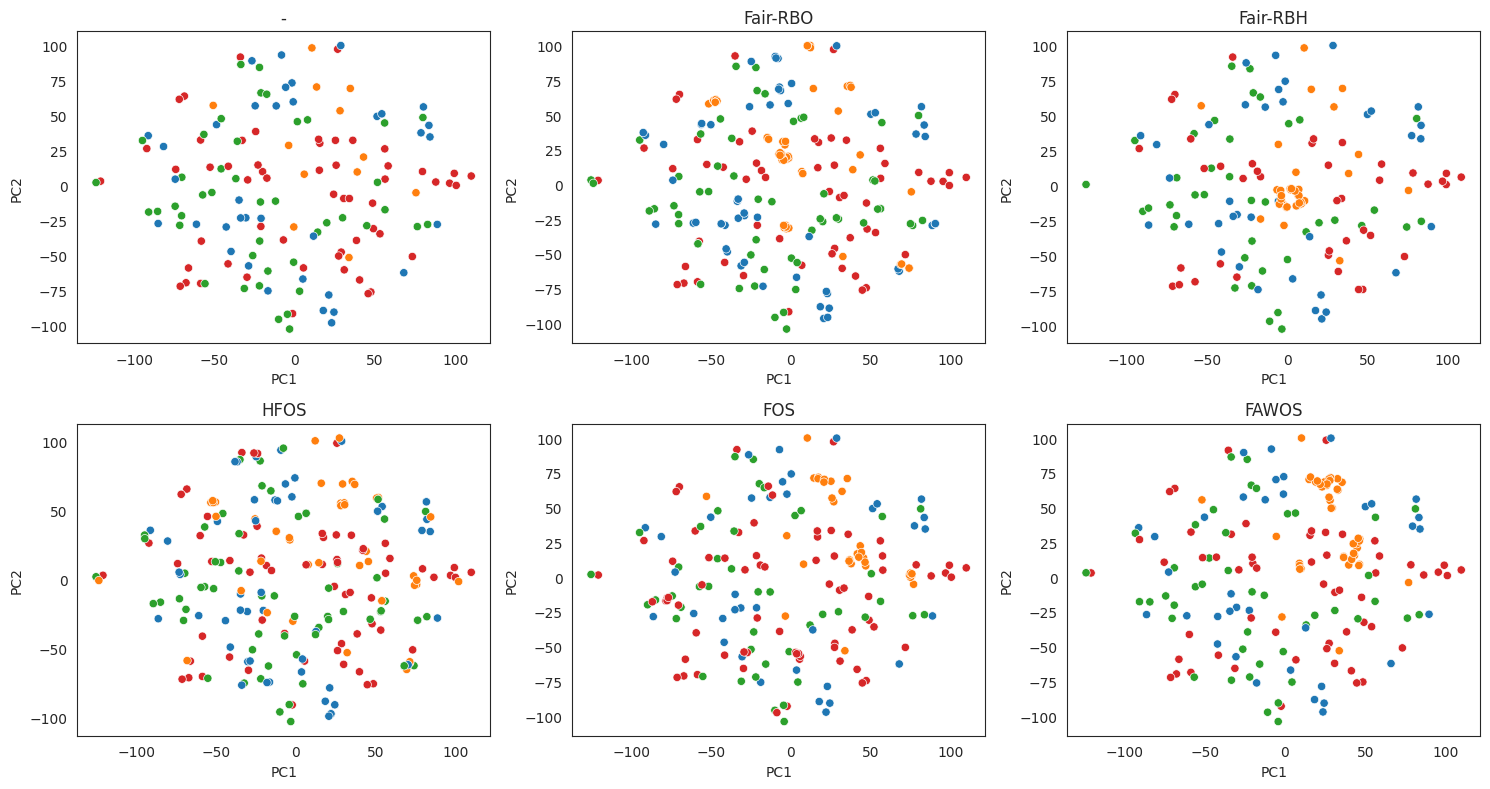

In [11]:
from src.datasets.bank_dataset import BankDataset
from src.datasets.adult_sampled_dataset import AdultSampledDataset
import os

sns.set_style("white")

dataset_name = 'heart_disease'
data_path = '../data'
algorithms = ['Fair-RBO', 'Fair-RBH', 'HFOS', 'FOS', 'FAWOS']
save_path = '../figures'
multi_bin = 'bin'
results_path = '../results'

for i in range(0, 1):
    print(i)
    all_data = []
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    dataset = init_dataset(dataset_name, random_state=42, data_path=data_path)
    for e, path in enumerate([f'{results_path}/fair_rbo_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fair_rbh_{dataset_name}_decision_tree/mean/', f'{results_path}/hfos_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fos_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fawos_{dataset_name}_decision_tree/2024-06-29/']):
        normal_data = os.path.join(path, f'train_{i}.csv')
        fair_data = os.path.join(path, f'fair_{i}.csv')
        if e == 0:
            normal_data = pd.read_csv(normal_data)
            normal_data = normal_data.iloc[: , 1:]
            all_data.append(normal_data)
        fair_data = pd.read_csv(fair_data)
        fair_data = fair_data.iloc[: , 1:]
        
        all_data.append(fair_data)
    fair_all = pd.concat(all_data)
    fair_df = dataset.perform_encoding('cont_ord_cat', fair_all, fair_all)
    pca_features_all = tsne(fair_df, dataset)
    print('done')
    for e, path in enumerate([f'{results_path}/fair_rbo_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fair_rbh_{dataset_name}_decision_tree/mean/', f'{results_path}/hfos_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fos_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fawos_{dataset_name}_decision_tree/2024-06-29/']):
        normal_data = os.path.join(path, f'train_{i}.csv')
        fair_data = os.path.join(path, f'fair_{i}.csv')
        results = os.path.join(path, f'fairness_{i}.csv')
        performance_res = os.path.join(path, f'performance_{i}.csv')
        test_data = os.path.join(path, f'test_{i}.csv')
        preds_train = os.path.join(path, f'train_preds_{i}.npy')
        preds_fair = os.path.join(path, f'fair_preds_{i}.npy')
        
        normal_data = pd.read_csv(normal_data)
        normal_data = normal_data.iloc[: , 1:]
        fair_data = pd.read_csv(fair_data)
        fair_data = fair_data.iloc[: , 1:]
        results = pd.read_csv(results)
        performance = pd.read_csv(performance_res)
        
        if e == 0:
            fig = explain_data(normal_data, all_data, dataset, fig, axs, e, '-', pca_features_all)
        
        fig = explain_data(fair_data, all_data, dataset, fig, axs, e + 1, algorithms[e], pca_features_all)
    # for ax in axs:
    #     ax.get_legend().set_visible(False)
    #plt.savefig(f'{save_path}/{dataset_name}_{multi_bin}.pdf')
    plt.show()
    print('========================================================================')

0
done


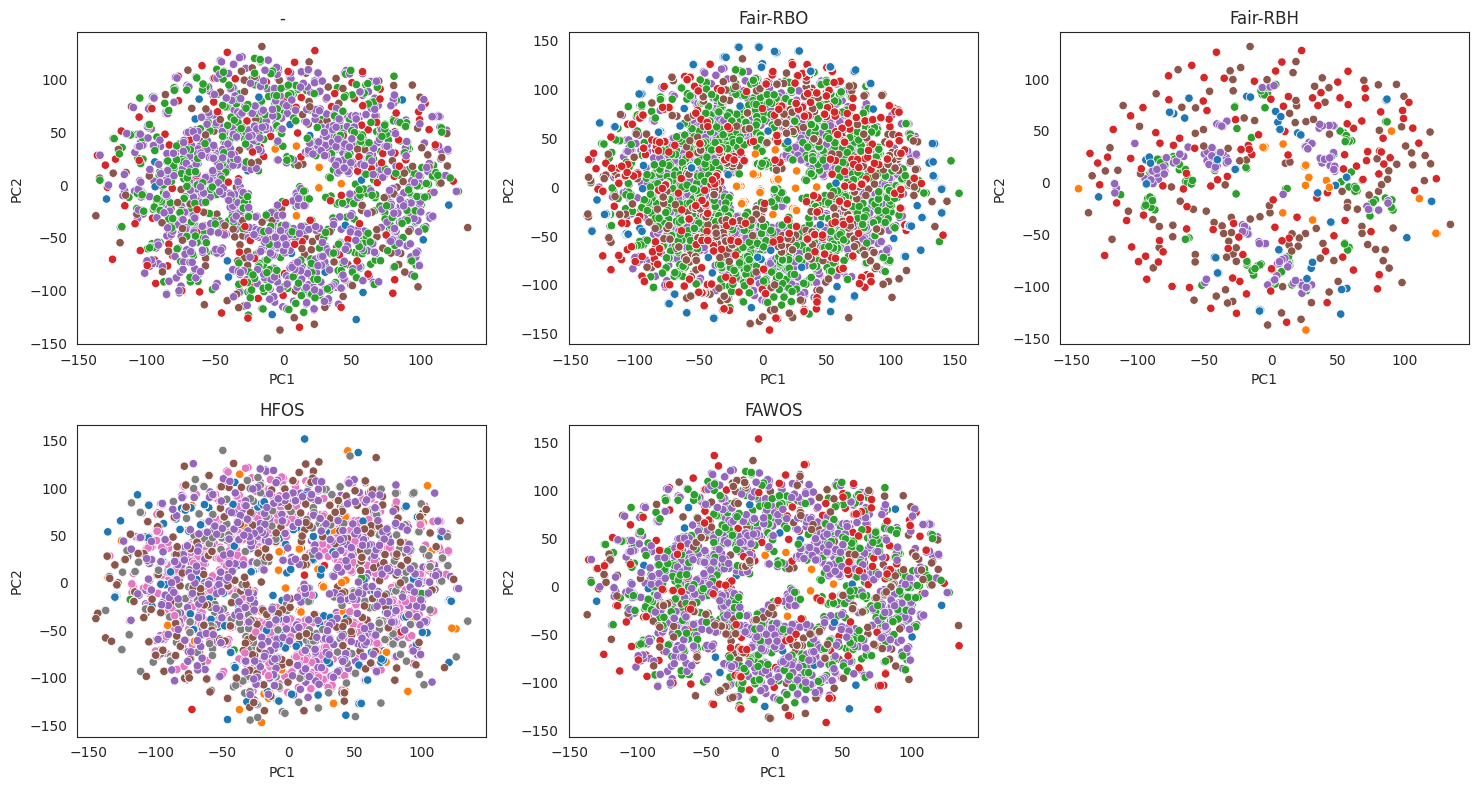

In [22]:
from src.validation_fhf_multi import init_dataset_multi
from src.datasets.bank_dataset import BankDataset
from src.datasets.adult_sampled_dataset import AdultSampledDataset
import os

sns.set_style("white")

dataset_name = 'bank'
data_path = '../data'
algorithms = ['Fair-RBO', 'Fair-RBH', 'HFOS', 'FAWOS']
save_path = '../figures'
multi_bin = 'multi'
results_path = '../results_multi'

for i in range(0, 1):
    print(i)
    all_data = []
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    dataset = init_dataset_multi(dataset_name, random_state=42, data_path=data_path)
    #dataset = init_dataset_(dataset_name, random_state=42, data_path=data_path)
    for e, path in enumerate([f'{results_path}/fair_rbo_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fair_rbh_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/hfos_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fawos_{dataset_name}_decision_tree/2024-06-29/']):
        normal_data = os.path.join(path, f'train_{i}.csv')
        fair_data = os.path.join(path, f'fair_{i}.csv')
        if e == 0:
            normal_data = pd.read_csv(normal_data)
            normal_data = normal_data.iloc[: , 1:]
            all_data.append(normal_data)
        fair_data = pd.read_csv(fair_data)
        fair_data = fair_data.iloc[: , 1:]
        # features, sensitive, target = get_features_groups_target(fair_data, dataset)
        # target = target[dataset.target]
        # sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
        # group_class = [f'{s}_{t}' for t, s in zip(target.to_list(), sensitive_groups.to_list())]
        # ids = [i for i, gg in enumerate(group_class) if gg in ['0.0_0.0_0.0', '0.0_0.0_1.0', '1.0_0.0_0.0', '1.0_0.0_1.0', '1.0_1.0_0.0', '1.0_1.0_1.0']]
        # 
        # fair_data = fair_data.iloc[ids, :]
        all_data.append(fair_data)
    fair_all = pd.concat(all_data)
    fair_df = dataset.perform_encoding('cont_ord_cat', fair_all, fair_all)
    pca_features_all = tsne(fair_df, dataset)
    print('done')
    for e, path in enumerate([f'{results_path}/fair_rbo_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fair_rbh_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/hfos_{dataset_name}_decision_tree/2024-06-29/', f'{results_path}/fawos_{dataset_name}_decision_tree/2024-06-29/']):
        normal_data = os.path.join(path, f'train_{i}.csv')
        fair_data = os.path.join(path, f'fair_{i}.csv')
        results = os.path.join(path, f'fairness_{i}.csv')
        performance_res = os.path.join(path, f'performance_{i}.csv')
        test_data = os.path.join(path, f'test_{i}.csv')
        preds_train = os.path.join(path, f'train_preds_{i}.npy')
        preds_fair = os.path.join(path, f'fair_preds_{i}.npy')
        
        normal_data = pd.read_csv(normal_data)
        normal_data = normal_data.iloc[: , 1:]
        fair_data = pd.read_csv(fair_data)
        fair_data = fair_data.iloc[: , 1:]
        # features, sensitive, target = get_features_groups_target(fair_data, dataset)
        # target = target[dataset.target]
        # sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
        # group_class = [f'{s}_{t}' for t, s in zip(target.to_list(), sensitive_groups.to_list())]
        # ids = [i for i, gg in enumerate(group_class) if gg in ['0.0_0.0_0.0', '0.0_0.0_1.0', '1.0_0.0_0.0', '1.0_0.0_1.0', '1.0_1.0_0.0', '1.0_1.0_1.0']]
        # 
        # fair_data = fair_data.iloc[ids, :]
        results = pd.read_csv(results)
        performance = pd.read_csv(performance_res)
        
        if e == 0:
            fig = explain_data(normal_data, all_data, dataset, fig, axs, e, '-', pca_features_all)
        
        fig = explain_data(fair_data, all_data, dataset, fig, axs, e + 1, algorithms[e], pca_features_all)
    axs[1,2].remove()
    # for ax in axs:
    #     ax.get_legend().set_visible(False)
    plt.savefig(f'{save_path}/{dataset_name}_{multi_bin}.pdf')
    plt.show()
    print('========================================================================')